In [1]:
# %matplotlib inline
%matplotlib notebook

try:
    from importlib import reload
except:
    pass

from __future__ import print_function ## Force python3-like printing

import os

from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import sfdmap

import numpy as np
from astropy.table import Table,Column

import pycoco as pcc

reload(pcc) ## FOR DEV
# reload(pcc.defaults)
# reload(pcc.functions)
# reload(pcc.classes)
# reload(pcc.utils)


import pyCoCo as pccsims

In [2]:
def convert_column_string_encoding(column):
    column = Column([pcc.utils.b(x) for x in column.data], name = column.name)
    return column

def get_mjdmax_BessellV(sn):
    v = sn.lcfit.spline["BessellV"]    
    mjd_spline = np.arange(np.nanmin(sn.phot.data["BessellV"]["MJD"]), 
                 np.nanmax(sn.phot.data["BessellV"]["MJD"]),
                 0.001)
    w = np.where(v(mjd_spline) == np.nanmax(v(mjd_spline)))

    mjdmax = mjd_spline[w]
    
    return mjdmax

In [3]:
filter_path = pcc._default_filter_dir_path
coco_root_path = pcc._default_coco_dir_path

coco = pccsims.pyCoCo(pcc.utils.b(filter_path), pcc.utils.b(coco_root_path))

Load in an templates object 

/Users/berto/Code/CoCo/data/lc/SN2009jf.dat
/Users/berto/Code/CoCo/data/lc/SN2009jf.dat


<IPython.core.display.Javascript object>


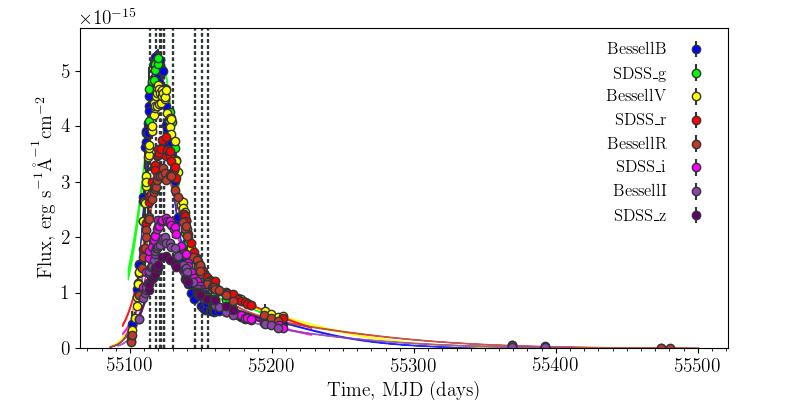

In [4]:
# snname = "SN2007uy"
snname = "SN2009jf"

sn = pcc.SNClass(snname)

phot_path = os.path.join(coco_root_path, "data/lc/", snname + ".dat")
speclist_path = os.path.join(str(coco_root_path),"lists/" + snname + ".list")
recon_filename = os.path.abspath(os.path.join(str(coco_root_path), "recon/", snname + ".dat"))

print(phot_path)
sn.load_phot(path = phot_path)
# sn.phot.plot()
sn.get_lcfit(recon_filename)

sn.load_list(path = speclist_path)
sn.load_spec()
# sn.load_mangledspec()
# sn.plot_spec()
# sn.plot_mangledspec()
sn.plot_lc(multiplot = False)

<IPython.core.display.Javascript object>


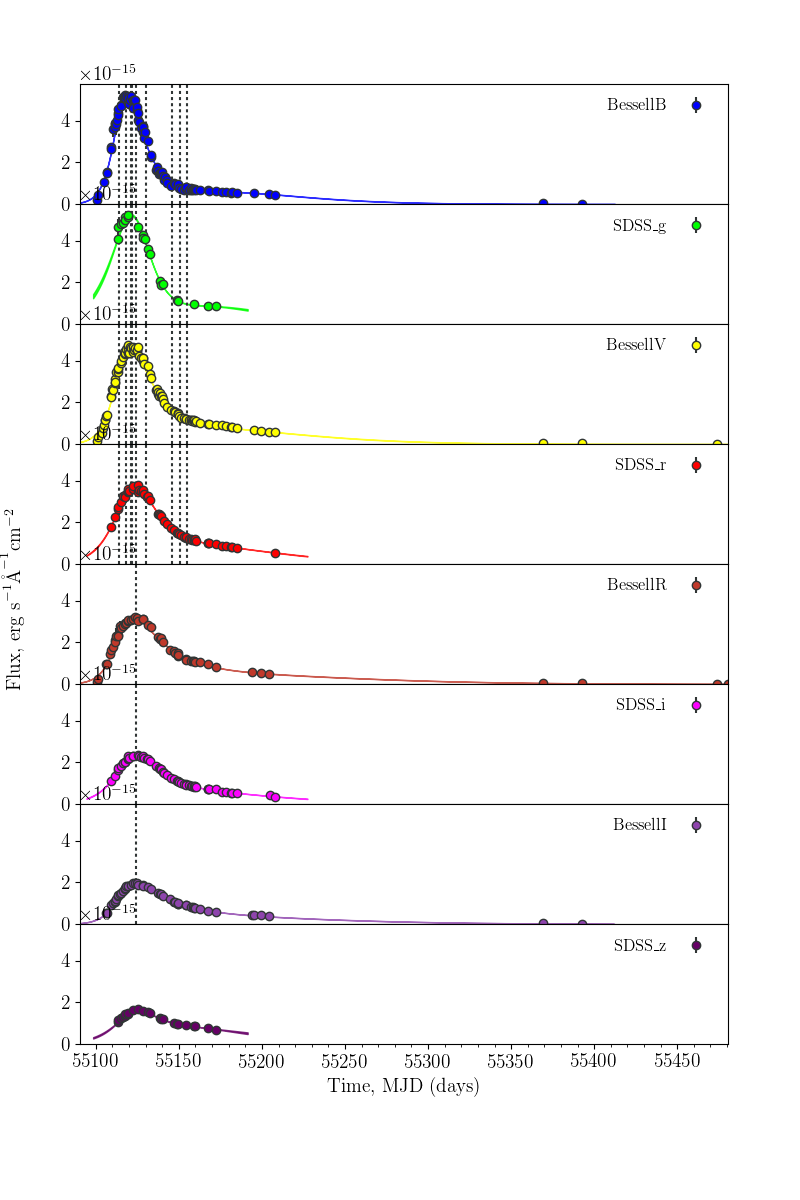

In [5]:
sn.plot_lc(multiplot = True, lock_axis=True)

/Users/berto/Code/verbose-enigma/pycoco/classes.py:215: UserWarning: WARNING: You passed something that was <class 'numpy.str_'>This might go wrong.
  StringWarning(filename)


<IPython.core.display.Javascript object>


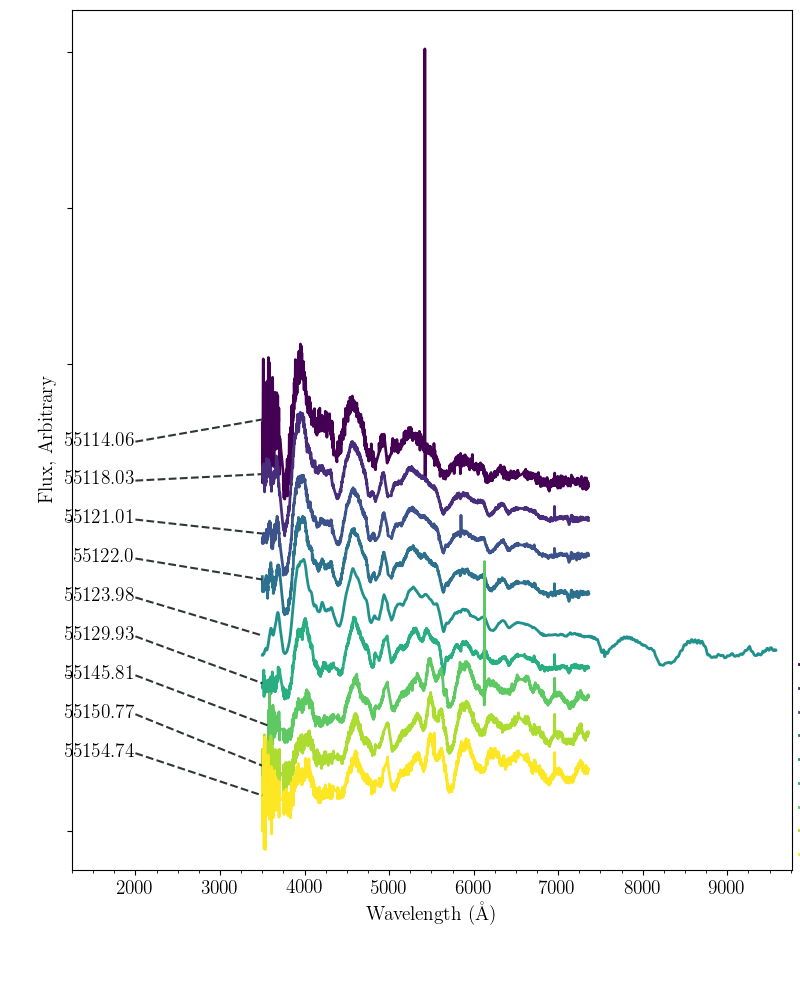

In [7]:
sn.load_mangledspec()
sn.plot_spec()

/Users/berto/Code/verbose-enigma/pycoco/functions.py:508: DeprecationWarning: invalid escape sequence \_
  plot_label_string = r'$\rm{' + orig_spec.data.meta["filename"].split('/')[-1].replace('_', '\_') + '}$'
/Users/berto/Code/verbose-enigma/pycoco/functions.py:514: DeprecationWarning: invalid escape sequence \_
  plot_label_string = r'$\rm{' + specfit.data.meta["filename"].split('/')[-1].replace('_', '\_') + '}$'


<IPython.core.display.Javascript object>


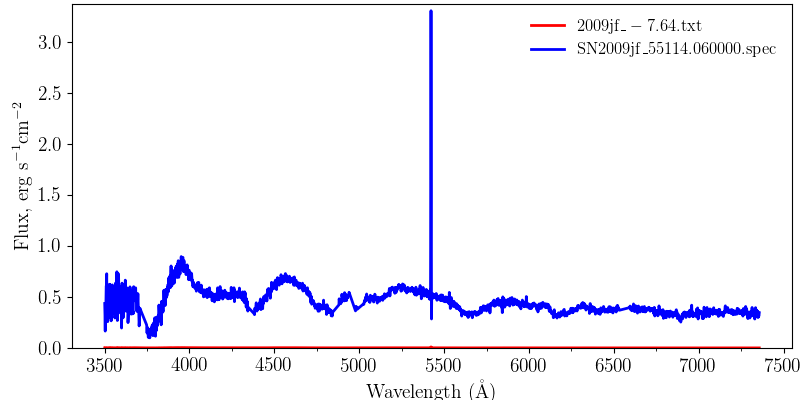

4.46149281437e-15 1.56896496295e-17


In [12]:
# sn.spec["2009jf_-7.64.txt"].data["wavelength"], sn.spec["2009jf_-7.64.txt"].data["flux"]
# 

# plt.plot(sn.spec["2009jf_-7.64.txt"].data["wavelength"], sn.spec["2009jf_-7.64.txt"].data["flux"], label = "spec")
# plt.plot(sn.mangledspec["SN2009jf_55114.060000.spec"].data["wavelength"], sn.mangledspec["SN2009jf_55114.060000.spec"].data["flux"], label = "mangled")
# plt.legend()
reload(pcc)
reload(pcc.functions)
pcc.compare_spec(sn.spec["2009jf_-7.64.txt"], sn.mangledspec["SN2009jf_55114.060000.spec"])

<IPython.core.display.Javascript object>


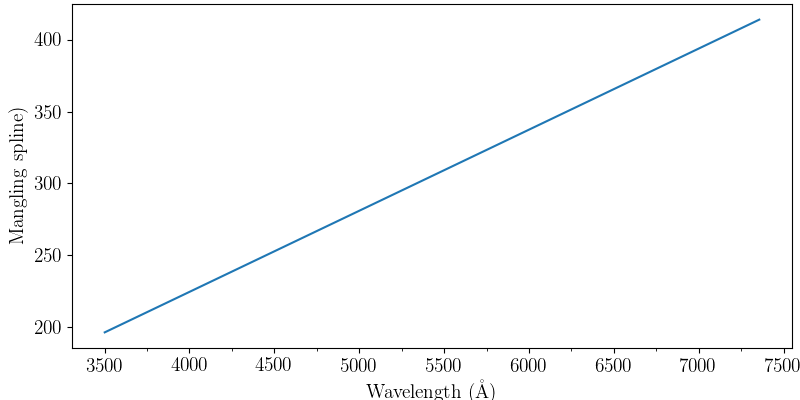

In [11]:
pcc.plot_mangle(sn.spec["2009jf_-7.64.txt"], sn.mangledspec["SN2009jf_55114.060000.spec"])

<IPython.core.display.Javascript object>


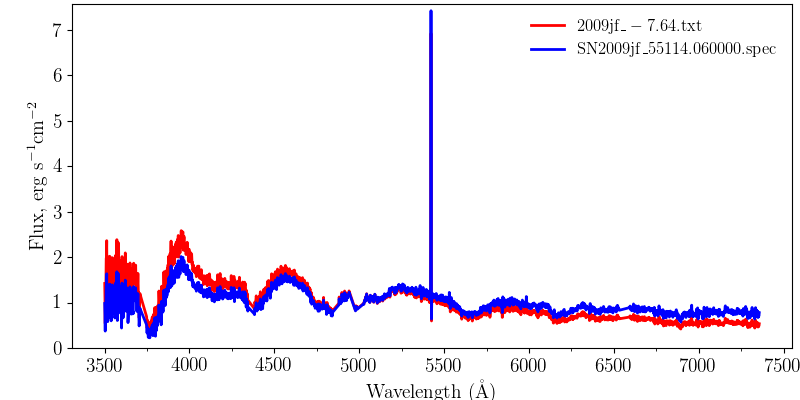

4.46149281437e-15 1.56896496295e-17


In [13]:
pcc.compare_spec(sn.spec["2009jf_-7.64.txt"], sn.mangledspec["SN2009jf_55114.060000.spec"], normalise=True)

In [10]:
plt.plot(sn.spec["2009jf_-7.64.txt"].data["wavelength"], sn.spec["2009jf_-7.64.txt"].data["flux"], label = "spec")


In [ ]:
plt.plot(sn.mangledspec["SN2009jf_55114.060000.spec"].data["wavelength"], sn.mangledspec["SN2009jf_55114.060000.spec"].data["flux"], label = "mangled")


In [14]:
from scipy.integrate import simps

def calc_spectrum_filter_flux(filter_name, SpecClass):
    filter_object = pcc.load_filter("/Users/berto/Code/CoCo/data/filters/" + filter_name + ".dat")
    filter_object.resample_response(new_wavelength = SpecClass.wavelength)
    filter_area = simps(filter_object.throughput, filter_object.wavelength)
    
    transmitted_spec = filter_object.throughput * SpecClass.flux

    integrated_flux = simps(transmitted_spec, SpecClass.wavelength)
    
    return  integrated_flux/filter_area

def calc_specphot(sn, filtername):

    specphot = np.array([])
    specepoch = np.array([])

    for spec in sn.mangledspec:
        specphot = np.append(specphot, calc_spectrum_filter_flux(filtername, sn.mangledspec[spec]))
        specepoch = np.append(specepoch, sn.mangledspec[spec].mjd_obs)
    
    return specepoch, specphot

def compare_phot_specphot(sn, filtername):
    """"""
    specepoch, specphot =  calc_specphot(sn, filtername)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(specepoch, specphot, label = "specphot")
    ax.scatter(sn.phot.data[filtername]["MJD"], sn.phot.data[filtername]["flux"], label = filtername)

    ax.set_ylim(0, 1.05 * np.nanmax(np.append(sn.phot.data[filtername]["flux"], specphot)))
    ax.legend()
#     plt.show()

<IPython.core.display.Javascript object>


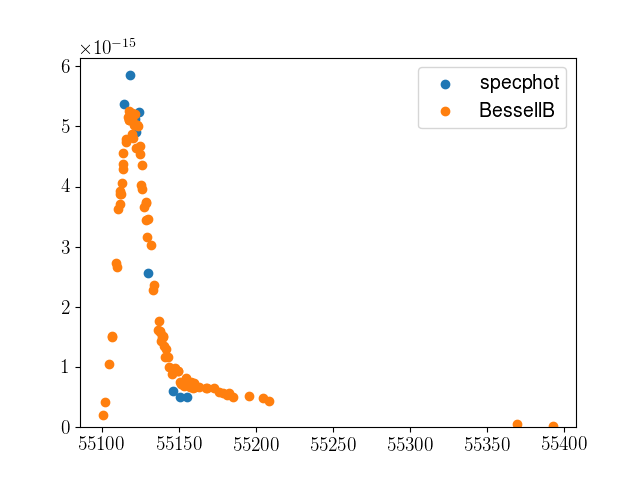

<IPython.core.display.Javascript object>


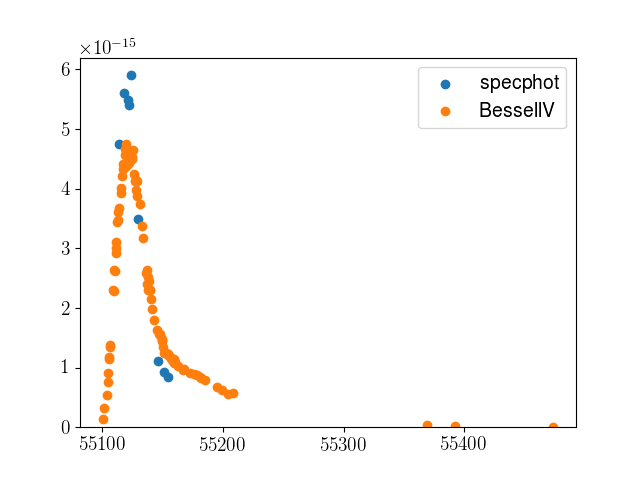

<IPython.core.display.Javascript object>


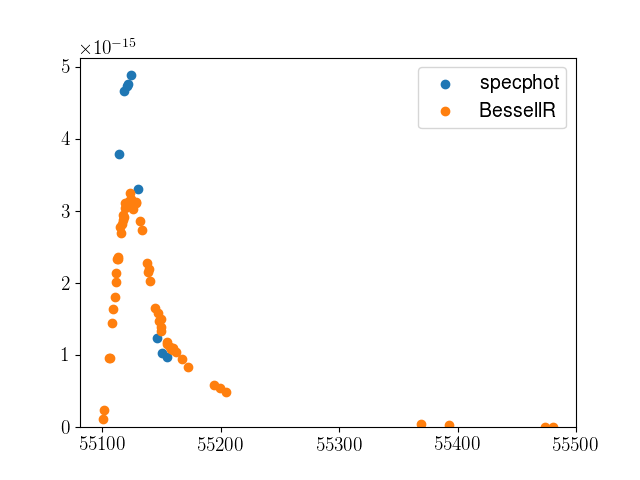

<IPython.core.display.Javascript object>


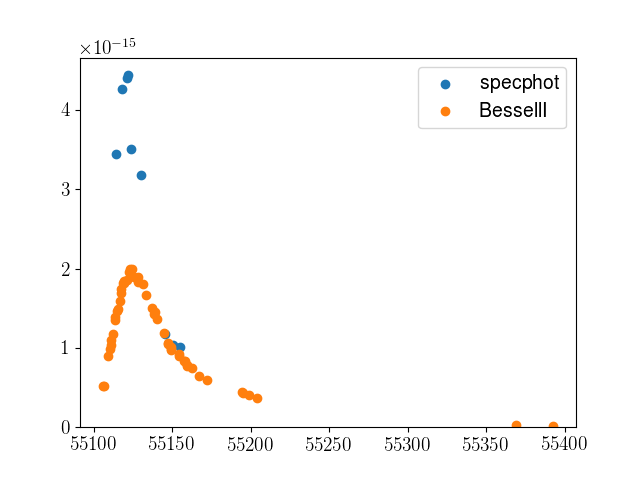

In [15]:
compare_phot_specphot(sn, "BessellB")
compare_phot_specphot(sn, "BessellV")
compare_phot_specphot(sn, "BessellR")
compare_phot_specphot(sn, "BessellI")


inputs:

* **`snname`**
* **`redshift`**
* **`absmag offset`**
* **`EBV MW`**
* **`EBV Host`**
* **`Rv`**
* **`MJD at Peak`**

* **`MJD to simulate`**
* **`filters to simulate`**

In [ ]:
sn.lcfit.get_fit_splines()

Quick check that the fit spline fits the fit (in Bessell V).
Note: spline sampled at MJDOBS so looks slightly linear.

In [ ]:
plt.plot(sn.phot.data["BessellV"]["MJD"], sn.lcfit.spline["BessellV"](sn.phot.data["BessellV"]["MJD"]), label = r"$\textnormal{Spline}$")
plt.scatter(sn.phot.data["BessellV"]["MJD"], sn.phot.data["BessellV"]["flux"], label = r"$\textnormal{Photometry}$")
plt.plot(sn.lcfit.data["BessellV"]["MJD"], sn.lcfit.data["BessellV"]["flux"], label = r"$\textnormal{Fit}$")
plt.legend()

In [ ]:
mjdmax = get_mjdmax_BessellV(sn)[0]

filters_to_sim = convert_column_string_encoding(sn.phot.phot["filter"]).data
mjd_to_sim = sn.phot.phot["MJD"].data

In [ ]:
verbose = False
# verbose = True

if verbose:
    print(mjdmax)
    print(mjd_to_sim)
    print(filters_to_sim)

In [ ]:
# tablepath = "/Users/berto/Code/verbose-enigma/testdata/info/info.dat"

# info = Table.read(tablepath, format = "ascii.commented_header")
info = pcc.load_info()

In [ ]:
z_obs = info.get_sn_info("SN2009jf")["z_obs"]
m = sfdmap.SFDMap()

print(z_obs)

In [ ]:
flux, flux_err = coco.simulate(b"SN2009jf", 
                    0.008, 2.9, 0.0, 0.0, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

# flux, flux_err = coco.simulate(b"SN2009jf", 
#                     0.008, 0.0, 0.1, 0.1, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)

In [ ]:
# pccsims.__file__

In [ ]:
p = pcc.PhotometryClass()

p.load_table(pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim))

In [ ]:
p.plot(legend=True)

In [ ]:
plt.scatter(p.data["BessellV"]["MJD"], p.data["BessellV"]["flux"], label = "Synthetic Bessell V")
plt.scatter(sn.phot.data["BessellB"]["MJD"], sn.phot.data["BessellB"]["flux"], label = "Real Bessell V")

plt.ylim(0, 1.02 *np.nanmax(np.append(p.data["BessellV"]["flux"], sn.phot.data["BessellB"]["flux"])))
plt.legend()

In [ ]:
sn.plot_lc(["BessellB"], multiplot = False)

In [ ]:
p.plot(["BessellB"])

In [ ]:
sn.plot_lc(multiplot=False)

In [ ]:
sn.load_mangledspec()

In [ ]:
sn.plot_mangledspec()

In [ ]:
sn.plot_spec()

In [ ]:
mjdmax = get_mjdmax_BessellV(sn)[0]

filters_to_sim = convert_column_string_encoding(sn.phot.data["BessellB"]["filter"]).data
mjd_to_sim = sn.phot.data["BessellB"]["MJD"].data

flux, flux_err = coco.simulate(b"SN2009jf", 
                    z_obs, -0.0, 0.2, 0.3, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

In [ ]:
plt.scatter(mjd_to_sim,sn.phot.data["BessellB"]["flux"])
plt.plot(sn.lcfit.data["BessellB"]["MJD"], sn.lcfit.data["BessellB"]["flux"])

plt.ylim(0, np.nanmax(sn.phot.data["BessellB"]["flux"])*1.1)

In [ ]:
p = pcc.PhotometryClass()

p.load_table(pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim))

In [ ]:
p.plot()

In [ ]:
# s = pcc.SpectrumClass()

# s.load("SN2009jf_55106.120000.spec", directory="/Users/berto/Code/CoCo/spectra/")

# s.plot()

In [ ]:
# s = pcc.SpectrumClass()
# s.load("SN2009jf_55108.130000.spec", directory="/Users/berto/Code/CoCo/spectra/")
# s.plot()

In [ ]:
# s = pcc.SpectrumClass()
# s.load("SN2009jf_55114.060000.spec", directory="/Users/berto/Code/CoCo/spectra/")
# s.plot()

In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table
def load_coords(filename = "sncoordinates.list"):
    """

    """
    path = os.path.abspath(os.path.join(pcc.__path__[0], os.path.pardir, filename))
    coordtable = Table.read(path, format = 'ascii.commented_header')
    return coordtable

In [ ]:
# %timeit load_coords()

In [ ]:
cootable = load_coords()

In [ ]:
%%timeit

snname = "SN2009jf"
w = np.where(cootable["snname"] == snname)
c = SkyCoord(cootable["RA"][w], cootable["Dec"][w], frame='icrs')


In [ ]:
c.ra.deg[0], c.dec.deg[0]

In [ ]:
import sfdmap

In [ ]:
m = sfdmap.SFDMap()

In [ ]:
m.ebv(c.ra.deg[0], c.dec.deg[0], unit = 'degree')